# Setup

In [174]:
import itertools
import math

import hoomd
import numpy

In [175]:
import os

fn = os.path.join(os.getcwd(), 'lattice.gsd')
![ -e "$fn" ] && rm "$fn"

In [176]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse('0.13.0')
FRESNEL_MAX_VERSION = packaging.version.parse('0.14.0')


def render(position, orientation, L):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )
    
    a = 0.1
    b = 0.1
    c = 0.7
    d = 0.5
    
    vertices = [
        (-a, -b, -d),
        (a, -b, -d),
        (a, b, -d),
        (-a, b, -d),
        (-a, -b, d),
        (a, -b, d),
        (a, b, d),
        (-a, b, d),
        (0.0, 0.0, c),
        (0.0, 0.0, -c),
    ]
    
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene, poly_info, N=len(position))
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
    )
    geometry.position[:] = position[:]
    geometry.orientation[:] = orientation[:]
    geometry.outline_width = 0.01
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_color = (1, 1, 1)
    scene.background_alpha = 1
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [177]:
m = 10
N_particles = 2 * m**2

In [178]:
spacing = 2
K = math.ceil(N_particles ** (1 / 2))
L = K * spacing

In [179]:
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
#position = list(itertools.product(x, repeat=3))
#print(position[0:4])

In [180]:
position = []

for a in x:
    for b in x:
        position.append((a, b, 0))

print(position[0:4])

[(np.float64(-15.0), np.float64(-15.0), 0), (np.float64(-15.0), np.float64(-13.0), 0), (np.float64(-15.0), np.float64(-11.0), 0), (np.float64(-15.0), np.float64(-9.0), 0)]


In [181]:
print(x)

[-15. -13. -11.  -9.  -7.  -5.  -3.  -1.   1.   3.   5.   7.   9.  11.
  13.]


In [182]:
position = position[0:N_particles]

In [183]:
print(N_particles)

200


In [184]:
#orientation = [(1, 0, 0, 0)] * N_particles
orientation = [(1, 0, 0, 0)] * N_particles

In [185]:
print(len(position))
print(len(orientation))

200
200


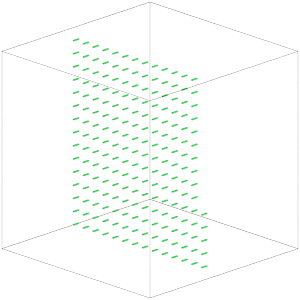

In [186]:
render(position, orientation, L)

## Writing the Configuration to the File System

[**GSD**](https://gsd.readthedocs.io/) files store the **periodic box**, particle **positions**, **orientations**,  and other properties of the state.
Use the **GSD** Python package to write this file.

In [187]:
import gsd.hoomd

In [188]:
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position
frame.particles.orientation = orientation

In [189]:
frame.particles.typeid = [0] * N_particles

In [190]:
frame.particles.types = ['ellipsoid']

In [191]:
frame.configuration.box = [L, L, 0, 0, 0, 0]   # 2D system

In [192]:
with gsd.hoomd.open(name='lattice.gsd', mode='x') as f:
    f.append(frame)

## Initializing a Simulation

You can use the file to initialize the **Simulation state**.
First, create a **Simulation**:

In [193]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu)

In [194]:
simulation.create_state_from_gsd(filename='lattice.gsd')

## Set up the Simulation

The following code block creates the **Simulation**, configures the HPMC **integrator**, and initializes the system **state** from `lattice.gsd` as has been discussed in previous sections in this tutorial:

In [195]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse('0.13.0')
FRESNEL_MAX_VERSION = packaging.version.parse('0.14.0')


def render(snapshot):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )
    L = snapshot.configuration.box[0]

    a = 0.05
    b = 0.5
    c = 0.7
    d = 0.05
    
    vertices = [
        (-a, -b, -d),
        (a, -b, -d),
        (a, b, -d),
        (-a, b, -d),
        (-a, -b, d),
        (a, -b, d),
        (a, b, d),
        (-a, b, d),
        (0.0, c, 0.0),
        (0.0, -c, 0.0),
    ]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(
        scene, poly_info, N=snapshot.particles.N
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.orientation[:] = snapshot.particles.orientation[:]
    geometry.outline_width = 0.01
    fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic.fit(scene)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [196]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)

mc = hoomd.hpmc.integrate.Ellipsoid()
mc.shape["ellipsoid"] = dict(a=0.05, b=0.7, c=0.05);

simulation.operations.integrator = mc
simulation.create_state_from_gsd(filename='lattice.gsd')

## Run the Simulation

Save a snapshot of the current state of the system.
This tutorial uses this later to see how far particles have moved.

In [197]:
initial_snapshot = simulation.state.get_snapshot()

In [198]:
simulation.run(1e4)

In [199]:
mc.translate_moves

(3883268, 114389)

In [200]:
mc.translate_moves[0] / sum(mc.translate_moves)

0.9713859893432578

In [201]:
mc.rotate_moves

(3950127, 52216)

In [202]:
mc.rotate_moves[0] / sum(mc.rotate_moves)

0.9869536419042546

In [203]:
mc.overlaps

0

## The Final Configuration

Look at the final particle positions and orientations and see how they have changed:

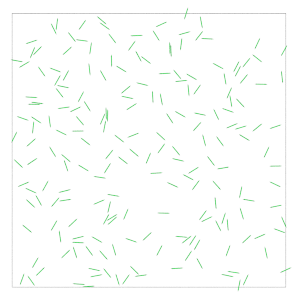

In [204]:
final_snapshot = simulation.state.get_snapshot()
render(final_snapshot)

In [205]:
initial_snapshot.particles.position[0:4]

array([[-15., -15.,   0.],
       [-15., -13.,   0.],
       [-15., -11.,   0.],
       [-15.,  -9.,   0.]])

In [206]:
final_snapshot.particles.position[0:4]

array([[ 10.05300893,   2.4862726 ,   0.        ],
       [  6.33557543,  -7.55138742,   0.        ],
       [ 14.99049476, -13.13227939,   0.        ],
       [  8.62760984,  -8.16546576,   0.        ]])

In [207]:
initial_snapshot.particles.orientation[0:4]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [208]:
final_snapshot.particles.orientation[0:4]

array([[-0.80313978,  0.        ,  0.        ,  0.59579065],
       [-0.52991829,  0.        ,  0.        , -0.8480487 ],
       [ 0.84215944,  0.        ,  0.        , -0.53922859],
       [-0.99897629,  0.        ,  0.        , -0.04523686]])

In [209]:
hoomd.write.GSD.write(state=simulation.state, mode='xb', filename='random.gsd')

## Volume Fraction

Self-assembly in hard particle systems typically occurs at a **volume fraction** above 0.5.
The **volume fraction** is the ratio of the volume occupied by the particles to the volume of the **periodic box**.

So far, this tutorial has **randomized** a system of *N* octahedra in a box with a very low volume fraction and stored that in `random.gsd`.
Initialize a **Simulation** with this configuration and see what volume fraction it is at:

In [210]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='random.gsd')

In [211]:
#a = math.sqrt(2) / 2
#V_particle = 1 / 2 * math.sqrt(2) * a**2
V_particle = 1.4 * 0.1

In [212]:
initial_volume_fraction = (
    simulation.state.N_particles * V_particle / simulation.state.box.volume
)
print(initial_volume_fraction)

0.031111111111111107


In [213]:
mc = hoomd.hpmc.integrate.Ellipsoid()
mc.shape["ellipsoid"] = dict(a=0.05, b=0.7, c=0.05);
simulation.operations.integrator = mc

## The QuickCompress Updater

An **Updater** is a type of **operation** in HOOMD-blue that makes changes to the **state**.
To use an **Updater**, first instantiate the object, assign a **Trigger**, and add it to the **Simulation**.
**Simulation** will apply the **Updater** on **time steps** where the **Trigger** returns `True`.
The **Periodic** trigger returns `True` every `period` steps.

**QuickCompress** is an **Updater** that works with HPMC to quickly compress the box to a target volume.
When triggered, **QuickCompress** reduces the box volume by a scale factor, while *allowing slight overlaps between the particles*.
It then waits for the translation and rotation **trial moves** to remove these overlaps before it reduces the volume again.
This process temporarily produces invalid system configurations, but is much quicker than a process that does not allow temporary overlaps.

Compute the final box size with a **volume fraction** above 0.5 and configure a **QuickCompress** to **trigger** every 10 **time steps**.

In [214]:
initial_box = simulation.state.box
final_box = hoomd.Box.from_box(initial_box)
final_volume_fraction = 0.8
final_box.volume = simulation.state.N_particles * V_particle / final_volume_fraction
compress = hoomd.hpmc.update.QuickCompress(
    trigger=hoomd.trigger.Periodic(10), target_box=final_box
)

In [215]:
simulation.operations.updaters.append(compress)

## The MoveSize Tuner

A **Tuner** is another type of **operation**.
**Tuners** make changes to other **operations** to improve performance.
In HPMC, the translation and rotation trial move sizes have a *huge* performance impact.
When the move size is too small it takes many time steps to make appreciable changes to the system.
When the move size is too large very few moves are accepted and it again takes many time steps to make appreciable changes.
The system makes the most progress at moderate move sizes and, in most cases, the optimal **acceptance ratio** is 20%.
The **MoveSize** tuner monitors the **acceptance ratio** and adjusts `d` and `a` to achieve the target.

The optimal move size depends on the density of the system.
**QuickCompress** changes the density rapidly during compression, so use the **MoveSize** tuner to adjust the move sizes regularly:

In [216]:
periodic = hoomd.trigger.Periodic(10)
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['a', 'd'],
    target=0.2,
    trigger=periodic,
    max_translation_move=0.2,
    max_rotation_move=0.2,
)
simulation.operations.tuners.append(tune)

## Run Until Complete

When the **QuickCompress** updater achieves the target box size and there are no overlaps between particles, the compression process is **complete**.
The number of time steps needed to achieve this varies based on parameters.
Check the `compress.complete` property regularly and stop running the simulation when the compression completes:

In [217]:
while not compress.complete and simulation.timestep < 1e6:
    simulation.run(1000)

In [218]:
simulation.timestep

14000

In [219]:
if not compress.complete:
    message = 'Compression failed to complete'
    raise RuntimeError(message)

In [220]:
mc.a['ellipsoid']

0.12420927447392349

In [221]:
mc.d['ellipsoid']

0.04903098477590668

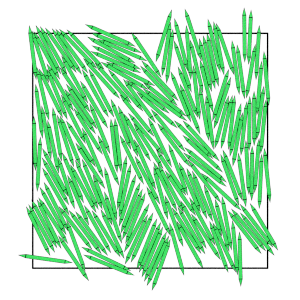

In [222]:
render(simulation.state.get_snapshot())

In [223]:
hoomd.write.GSD.write(state=simulation.state, mode='xb', filename='compressed.gsd')

## Equilibration

So far, this tutorial has placed *N* non-overlapping octahedra randomly in a box and then compressed it to a moderate volume fraction.
The resulting configuration of particles is valid, but strongly dependent on the path taken to create it.
There are many more **equilibrium** configurations in the set of possible configurations that do not depend on the path.
**Equilibrating** the system is the process of taking an artificially prepared state and running a simulation.
During the simulation run, the system will relax to **equilibrium**.
Initialize the **Simulation** first:

In [224]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)
mc = hoomd.hpmc.integrate.Ellipsoid()
mc.shape["ellipsoid"] = dict(a=0.05, b=0.7, c=0.05);
simulation.operations.integrator = mc

In [225]:
simulation.create_state_from_gsd(filename='compressed.gsd')

## Writing Simulation Trajectories

Save the system **state** to a file periodically so that you can observe the equilibration process.
This tutorial previously used **GSD** files to store a single frame of the system **state** using either the **GSD** Python package or `GSD.write`.
The **GSD Writer** (another **operation**) will create a **GSD** file with many frames in a **trajectory**.

We use the `'xb'` mode to open the file to ensure that the file does not exist before opening it.
If the file does exist an error will be raised rather than overwriting or appending to the file.

In [226]:
gsd_writer = hoomd.write.GSD(
    filename='trajectory.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

## Tuning the Trial Move Size

The previous section used the **MoveSize** tuner regularly during compression to adjust `d` and `a` to achieve a target **acceptance ratio** while the system density changed rapidly.
Use it again during the equilibration run to ensure that HPMC is working optimally.

Move sizes should be tuned briefly at the beginning, then left constant for the duration of the run.
Changing the move size throughout the simulation run violates *detailed balance* and can lead to incorrect results.
Trigger the **tuner** every 100 steps but only for the first 5000 steps of the simulation by combining a **Periodic** and **Before** trigger with an **And** operation.
**Before** returns `True` for all **time steps** `t < value` and the **And** trigger returns `True` when all of its child triggers also return `True`.

In [227]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['a', 'd'],
    target=0.2,
    trigger=hoomd.trigger.And(
        [hoomd.trigger.Periodic(100), hoomd.trigger.Before(simulation.timestep + 5000)]
    ),
)
simulation.operations.tuners.append(tune)

In [228]:
simulation.run(5000)

In [229]:
simulation.run(100)

In [230]:
rotate_moves = mc.rotate_moves
mc.rotate_moves[0] / sum(mc.rotate_moves)

0.20143182557761147

In [231]:
translate_moves = mc.translate_moves
mc.translate_moves[0] / sum(mc.translate_moves)

0.19669920850915082

## Equilibrating the System

To equilibrate the system, **run** the simulation.
The length of the run needed is strongly dependent on the particular model, the system size, the density, and many other factors.
Hard particle Monte Carlo self-assembly often takes tens of millions of time steps for systems with ~10,000 particles.
This system is much smaller, so it takes fewer steps.

<div class="alert alert-warning">
This cell may require several minutes to complete.
</div>

In [232]:
simulation.run(1e5)

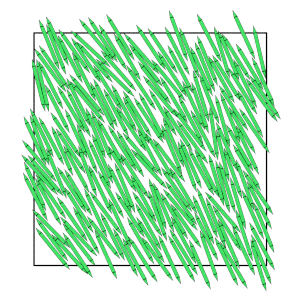

In [233]:
render(simulation.state.get_snapshot())

In [234]:
gsd_writer.flush()

In [235]:
import math
import numpy as np

import freud
import rowan
import gsd.hoomd
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [236]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import io
import warnings

import fresnel
import IPython
import numpy
import packaging.version
import PIL

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse('0.13.0')
FRESNEL_MAX_VERSION = packaging.version.parse('0.14.0')


def render(snapshot, particles=None, is_solid=None):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )
    a = 0.05
    b = 0.5
    c = 0.7
    d = 0.05
    
    vertices = [
        (-a, -b, -d),
        (a, -b, -d),
        (a, b, -d),
        (-a, b, -d),
        (-a, -b, d),
        (a, -b, d),
        (a, b, d),
        (-a, b, d),
        (0.0, c, 0.0),
        (0.0, -c, 0.0),
    ]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)
    N = snapshot.particles.N
    L = snapshot.configuration.box[0]
    if particles is not None:
        N = len(particles)
    if is_solid is not None:
        N = int(numpy.sum(is_solid))

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene, poly_info, N=N)
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
    )
    if particles is None and is_solid is None:
        geometry.position[:] = snapshot.particles.position[:]
        geometry.orientation[:] = snapshot.particles.orientation[:]
    elif particles is not None:
        geometry.position[:] = snapshot.particles.position[particles, :]
        geometry.orientation[:] = snapshot.particles.orientation[particles, :]
    elif is_solid is not None:
        geometry.position[:] = snapshot.particles.position[
            numpy.ix_(is_solid, [0, 1, 2])
        ]
        geometry.orientation[:] = snapshot.particles.orientation[
            numpy.ix_(is_solid, [0, 1, 2, 3])
        ]

    geometry.outline_width = 0.01
    fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic.fit(scene)
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=500)


def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render(frames[0], particles, is_solid[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert(
        'P', palette=PIL.Image.Palette.ADAPTIVE
    )
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f, particles, is_solid[i])
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if size > 3000:
        warnings.warn(f'Large GIF: {size} KiB')
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

## Read the Trajectory

Use **GSD** to open the **trajectory** generated by the previous section of this tutorial.

In [237]:
traj = gsd.hoomd.open('trajectory.gsd')

In [238]:
len(traj)

105

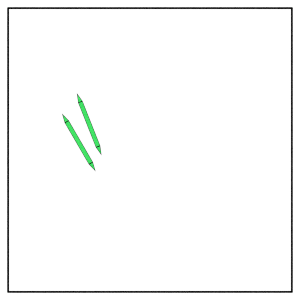

In [239]:
render_movie(traj[0:50:5], particles=[12, 18])

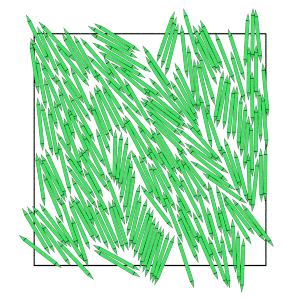

In [240]:
render_movie(traj[0:150:4])

In [241]:
order_params = []
nematic = freud.order.Nematic()
starting_orientation = np.array([1, 0, 0])

for frame in traj:
    orientations = rowan.rotate(frame.particles.orientation, starting_orientation)
    nematic.compute(orientations)
    order_params.append(nematic.order)

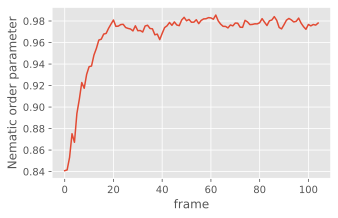

In [242]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
order_param = numpy.array([numpy.sum(a) for a in order_params])
ax.plot(order_param)
ax.set_xlabel('frame')
ax.set_ylabel('Nematic order parameter')
fig